# Predicting Pulsar Stars (group 26 project proposal)

## Introduction

Our group has chosen the Pulsar Star Data as our research dataset. Fundamentally, a pulsar is a type of neutron star that emits energy which is detectable through current technology. These metrics are collected to help astronomers and astrophysicists test theories and models; for instance, Albert Einstein’s theory of General Relativity. However, the signals collected may not necessarily identify the presence of a pulsar, as some of the signals can potentially be human-produced radio signals bounced back from space. To determine the legitimacy of these signals, we will work through the pulsar data through a series of classification methods. This [link](https://archive.ics.uci.edu/dataset/372/htru2) is the original source of the dataset we used. The pulsar data set includes nine columns. The first eight columns contains the following variables as listed below:

- Mean of the integrated profile.
- Standard deviation of the integrated profile.
- Excess kurtosis of the integrated profile.
- Skewness of the integrated profile.
- Mean of the DM-SNR curve.
- Standard deviation of the DM-SNR curve.
- Excess kurtosis of the DM-SNR curve.
- Skewness of the DM-SNR curve.

These variables contribute to the results of the ninth row, which contains an integer result, either “0” or “1”. “0” is identified as non-pulsar signals while “1” is identified as pulsar signals.

The question we seek to answer with our project is whether any given new observation is a pulsar or not.


## Preliminary exploratory data analysis

### 1. Loading necessary libraries and initialization

In [1]:
library(tidyverse)
library(tidymodels)
library(reshape2)
install.packages("kknn")

set.seed(2020) # a constant seed to keep the analysis reproducible

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### 2. Reading data from web

We have uploaded the data file to a public git repository and we will read the data from there into R. Since there are no column names in the file, we will assign column names manually.

In [2]:
# read the data and assign column names
pulsar_data <- read_csv("https://raw.githubusercontent.com/sinamhdv/DSCI-100-project-group-26/main/HTRU_2.csv", col_names = FALSE)
colnames(pulsar_data) <- c("profile_mean", "profile_stdev", "profile_skewness", "profile_kurtosis", "dm_mean", "dm_stdev", "dm_skewness", "dm_kurtosis", "class")
head(pulsar_data, n = 6)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


profile_mean,profile_stdev,profile_skewness,profile_kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


### 3. Cleaning and wrangling data
The data is already in tidy format. However, since the "class" variable is read as a double, we will change it to factor:

In [3]:
# change class to factor
pulsar_data <- pulsar_data |>
    mutate(class = as.factor(class))

### 4. Splitting train and test data

In [4]:
# train-test split
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

### 5. Summarizing training data (exploratory data analysis)

We will summarize the data by calculating the mean of every numeric variable for each class, and also counting observations in each class. Then, we will count the number of missing entries in each column, all of which appear to be zero according to the second table below:

In [5]:
# summarize data
pulsar_train |>
    group_by(class) |>
    summarize(class_count = n(), across(profile_mean:dm_kurtosis, mean))

summarize(pulsar_train, across(profile_mean:dm_kurtosis, ~ sum(is.na(.x))))

class,class_count,profile_mean,profile_stdev,profile_skewness,profile_kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,12191,116.59107,47.35960,0.2105783,0.3748928,8.856504,23.36976,8.869708,114.12993
1,1232,56.39016,38.68141,3.1515890,15.7121522,50.135168,56.93902,2.681218,16.72433


profile_mean,profile_stdev,profile_skewness,profile_kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0


According to the first table, the number of positive class observations is significantly lower than negative classes. Therefore, we will probably need to balance the data by upsampling to prevent this from affecting our model.

### 6. Visualizing training data (exploratory data analysis)

We will draw a histogram for every variable to see the distribution of variables. Also, we will draw a correlation heatmap to help us determine the variables that can be better for predicting the target class.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


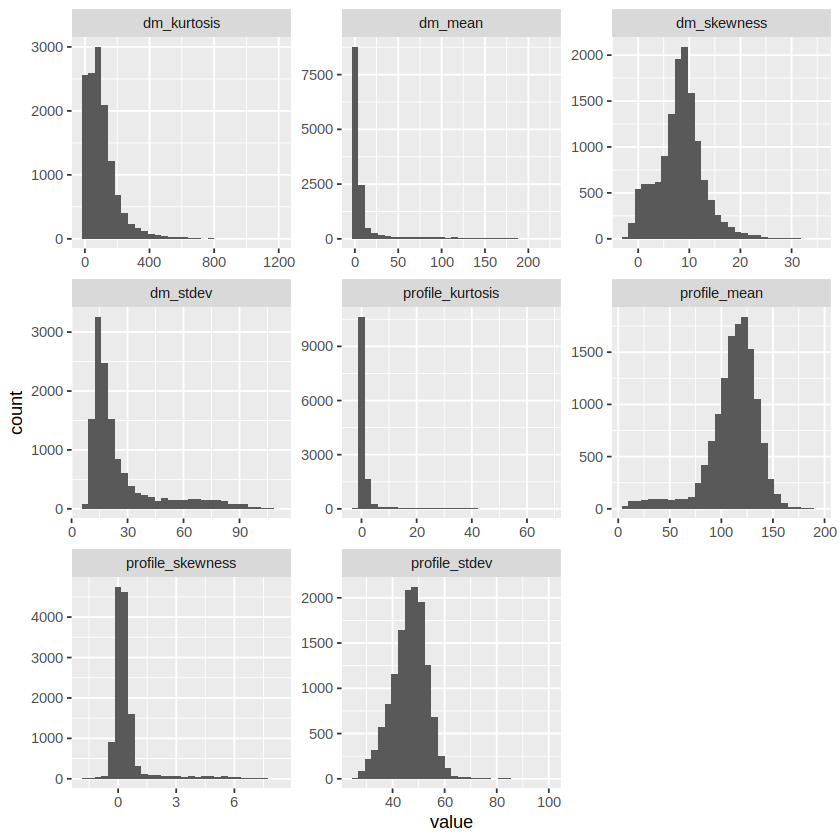

In [6]:
# visualize the data
long_data <- pulsar_train |>
    select(profile_mean:dm_kurtosis) |>
    gather(column_name, value)

hist_plots <- ggplot(long_data, aes(x = value)) +
    geom_histogram() +
    facet_wrap(~ column_name, scales = "free")

hist_plots

According to the histograms, profile_mean and profile_stdev have distributions similar to a normal distribution, However, the other variables do not have normal distribution, and most of their observations are concentrated around smaller values of their range.

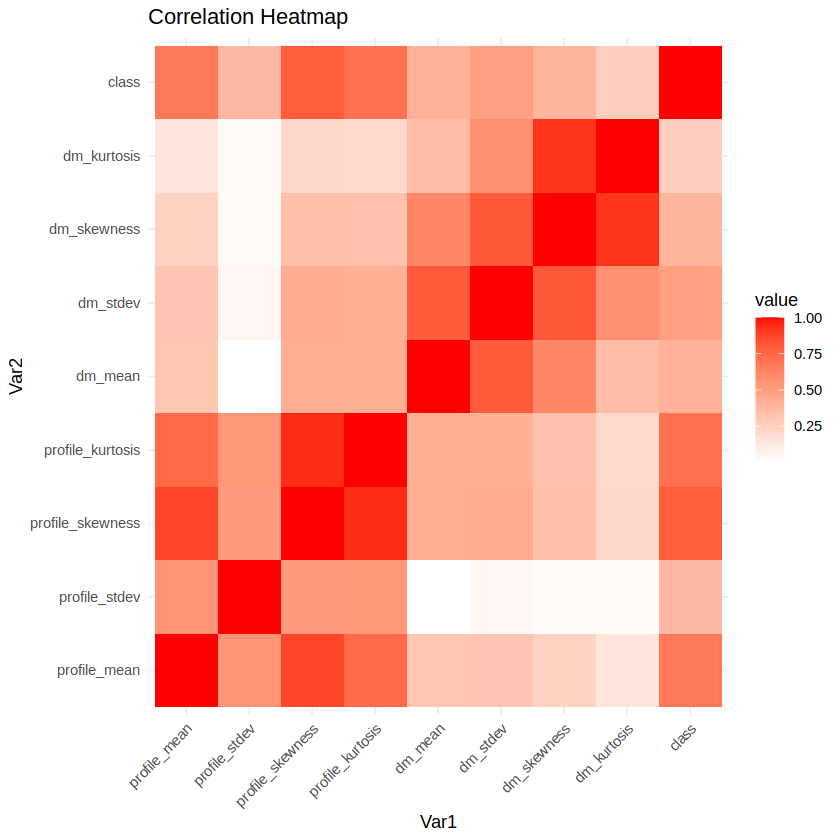

In [7]:
# draw correlation heatmap

# create a correlation matrix
correlation_matrix <- pulsar_train |>
    mutate(class = as.numeric(class)) |>
    cor()

# change the matrix to dataframe and change values to absolute values
cor_df <- melt(correlation_matrix) |>
    mutate(value = abs(value))

ggplot(cor_df, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "red") +
  labs(title = "Correlation Heatmap") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

According to the correlation heatmap above, profile_kurtosis, profile_skewness, and profile_mean have the largest absolute values of correlation with the target class. Therefore, we will be using these variables as predictors in our model.

## Methods

As we are seeking to answer a question oriented around classification, we will implement the appropriate methods that come along with it, such as training and testing. We will use the K-nearest neighbors algorithm and use cross validation to find the an optimal value of K. Furthermore, other considerations like standardization and data balancing will have to be made. Since the number of observations from the classes are not balanced, we will use up-sampling to balance the data. As explained in the previous section about the correlation heatmap, we will be using profile_kurtosis, profile_skewness, and profile_mean as predictor variables for our model as these variables have the highest absolute values of correlation with the target class.

In the end, we will compute accuracy for our model and show the confusion matrix to calculate precision and recall as well. We will visualize the results by drawing a line plot of model accuracy for different values of K.

## Expected outcomes and significance

In the end, we expect to have a model that can predict pulsar emissions from radio noise with reasonable accuracy. This will lead to the identification of true pulsar signals in a faster and more efficient way. As pulsars are of considerable scientific interest in astronomy, this will help scientists working in this area.

One other question and challenge that this can lead to is to predict multi-class labels for signals to detect different types of pulsars. This can be achieved using a multi-class dataset and by training a multi-class classifier in the future.